In [24]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
import mplleaflet
from  pyproj import Proj
from SimPEG import Mesh


if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
#     sharedir = datadir.joinpath('SWIlarge/data/GIS')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    simpegskytem_path = '../../'
    
    
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    sharedir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = sharedir

nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')



#Local imports and file creation
if not simpegskytem_path in sys.path:
    sys.path.append(simpegskytem_path)

import simpegskytem
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey,Utils

import config
from set_rc import *


for d in (figdir,outputdir):
    if not d.exists():
        d.mkdir()


p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

In [25]:
#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%

In [26]:
%%time

nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')
m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


'''
#If need be, write a skeleton of m_nm for faster loading
m_nm.model_ws = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty').as_posix()



for p in m_nm.get_package_list():
    if p != 'DIS':
        try:
            m_nm.remove_package(p)
        except:
            pass
m_nm.write_input()
'''

CPU times: user 406 ms, sys: 38.1 ms, total: 445 ms
Wall time: 449 ms


In [32]:
start_nm_yr = 1979
start_nm_mo = 10
start_nm_str = 'Oct 1979'
end_nm_yr = 2011
end_nm_mo = 9
end_nm_str = 'Sep 2011'
Lt_nm = ( (end_nm_yr + end_nm_mo/12)  - (start_nm_yr + start_nm_mo/12) )     *365
start_nm_datetime='{}/1/{}'.format(start_nm_mo,start_nm_yr)



start_m_yr = 1979
start_m_mo = 10
start_m_str = 'Oct 1979'
end_m_yr = 2011
end_m_mo = 9
end_m_str = 'Sep 2011'
Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)


In [33]:
#Name model
modelname = 'test_simpleSWI'
model_ws = workdir.joinpath("test_simpleSWI")
#Name model
sw_exe = config.swexe #set the exe path for seawat

#Model discretization
Lz = 150.

nrow,ncol,nlay,nper = m_nm.nrow_ncol_nlay_nper

# rows = np.arange(100,102)
rows = np.arange(160,165)
# rows = np.arange(nrow)

cols = np.arange(ncol)
nrow =len(rows)
ncol = len(cols)
nlay=20


henry_top = 2
ocean_elev = 0
delv_first = 4
botm_first = henry_top-delv_first


delv = (Lz-delv_first) / (nlay-1)
delr = m_nm.dis.delr.array[0]
delc = m_nm.dis.delc.array[0]

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]


topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
henry_top = topo_grid[(slice(rows[0],rows[-1]+1),slice(cols[0],cols[-1]+1))]
# henry_top = np.zeros((nrow,ncol))



# beachslope = .05
# ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
# ocean_col = [np.floor(ncol/2).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

# inland_elev = beachslope*ocean_col[0]*delr
# offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
# nyrs= 2
# Lt = 365*nyrs #Length of time in days

perlen = list(np.repeat(365/2,int(Lt_m/(365/2))))
nper = len(perlen)
nstp = np.ones_like(perlen,dtype=np.int)

# nstp = m_nm.dis.nstp.array
# perlen = m_nm.dis.perlen.array
# nper = m_nm.nper





steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.1
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt_m,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
# SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,
                               start_datetime=start_m_datetime)

# xll=595855
# yll = 4059438
# rotation=-13.5
# p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

m.DIS.lenuni = 2
m.DIS.itmuni=4
m.DIS.rotation=-13.5
# m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m.DIS.proj4_str = p.srs
xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]


m.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation,epsg=26910)# proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)



Model setup: 
nlay: 20
nrow: 5
ncol: 345
Total cells: 34500
Total time: 11649.583333333361 days
nper: 63

test_simpleSWI.nam
adding Package:  DIS
xll:597776.1386218522; yll:4067440.118259913; rotation:-13.5; proj4_str:epsg:26910; units:undefined; lenuni:0


In [34]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())


flopy.modflow.ModflowDis(m_empty, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,start_datetime=start_m_datetime)

m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


### Gridgen make grid

### Import AEM data

In [35]:
df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]

In [63]:
def utmrotate(x,y,x0=595855,y0=4059438,rotation=13.5,local=False):
    rotation = rotation*np.pi/180
    if local:
        orig_x,orig_y = (0,0)
    else:
        orig_x,orig_y = (x0,y0)
        
    x_rot = np.cos(rotation)*(x-x0) - np.sin(rotation)*(y-y0) + orig_x
    y_rot = np.sin(rotation)*(x-x0) + np.cos(rotation)*(y-y0) + orig_y
    return x_rot,y_rot  
def global_to_local(x_glob,y_glob,rotx0=xll,roty0=yll,x0_local=xmll_rot,y0_local=ymll_rot):
    x_temp,y_temp = utmrotate(x_glob,y_glob,local=False,x0=rotx0,y0=roty0)
    x_temp -= x0_local
    y_temp -= y0_local
    return np.stack((x_temp,y_temp),axis=1)

In [65]:
from shapely.geometry import Point, Polygon
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
iskip=6



#xll,yll for local grid
xmll,ymll = m_empty.modelgrid.xvertices[-1,0],m_empty.modelgrid.yvertices[-1,0]
xmll_rot,ymll_rot = utmrotate(xmll,ymll,x0=xll,y0=yll)

#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
# msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
x_m_rot,y_m_rot = utmrotate(m_empty.modelgrid.xvertices.flatten(),m_empty.modelgrid.yvertices.flatten(),local=False)


xy_global = df.loc[msk,['UTMX', 'UTMY']].values[::iskip]
xy = global_to_local(xy_global[:,0],xy_global[:,1])
Line = df.loc[msk,['LINE_NO']].values[::iskip]
dem = df.loc[msk,'ELEVATION'].values[::iskip]
height = df.loc[msk,'INVALT'].values[::iskip]
system = df.loc[msk,'skytem_type'].values[::iskip]
msk_312 = system==312
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values
n_sounding= xy.shape[0]




dx,dy,dz = (m_empty.dis.delr.array[0],
            m_empty.dis.delc.array[0],
            m_empty.dis.botm[-1] - m_empty.dis.botm[-2])


print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n'
'skytem_type',skytem_type.shape,'\n')

#nodenumber in grid corresponding to AEM locations
# nodenumber_AEM = g.intersect(list(xy_global),'point',0).nodenumber

msk (25776,) 
xy (65, 2) 
Line (65, 1) 
dem (65,) 
height (65,) 
system (65,) 
rx_locations (65, 3) 
src_locations (65, 3) 
topo (65, 3) 
skytem_type (25776,) 



In [66]:
def intersect_swi_contour(aquifer=180,yr_ind=None):
    if aquifer==180:
        yr = yrs_180[yr_ind]
        f = sharedir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    elif aquifer==400:
        yr = yrs_400[yr_ind]
        f = sharedir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    else:
        raise('enter either 180 or 400')
    int_obj = g.intersect(f,'polygon',layer=layer)
    a = np.zeros((g.nodes), dtype=np.int)
    a[int_obj.nodenumber] = 1
    return a.reshape((nlay,nrow,ncol),order='C')


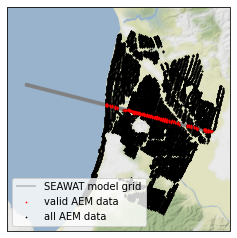

In [67]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid',alpha=.5)

ax.set_extent([596000., 620000.,4052000., 4075962.], crs=transform)

plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='r',s=.5,transform=transform,label='valid AEM data',zorder=3)
plt.scatter(df.loc[~msk,'UTMX'],df.loc[~msk,'UTMY'],c='k',s=.5,transform=transform,label='all AEM data',zorder=2)


# shp180 =  flopy.plot.plot_shapefile(f_shp_400,ax=ax,transform=transform,                        
#                           facecolor='none',edgecolor='r',label='Cl. contour 180-FA')
# shp400 =flopy.plot.plot_shapefile(f_shp_180,ax=ax,transform=transform,                        
#                           facecolor='none',edgecolor='orange',label='Cl. contour 400-FA')
plt.legend()
# plt.savefig(figdir.joinpath('AEM_valid_fieldsite.png'),dpi=300,bbox_inches='tight')

#### Make layer_mapping_ind

In [68]:
from scipy.interpolate import griddata

def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)

botm_orig= m_nm.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros((nlay,nrow,ncol),dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
#         botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        botm_orig_lay = make_surf(botm_orig[-1],m_nm,m_empty)
        ind_inlay = m_empty.dis.botm.array<botm_orig_lay
    else:
        botm_orig_lay = make_surf(botm_orig[lay],m_nm,m_empty)
        top_orig_lay = make_surf(botm_orig[lay-1],m_nm,m_empty)
        ind_inlay =np.logical_and(m_empty.dis.botm.array>=botm_orig_lay,
                                  m_empty.dis.botm.array<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay
    
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


In [69]:
    nlay,nrow,ncol = (m_empty.nlay,
                      m_empty.nrow,
                      m_empty.ncol)
    dx,dy,dz = (m_empty.dis.delr.array[0],
                m_empty.dis.delc.array[0],
                 m_empty.dis.botm[-2]-m_empty.dis.botm[-1])
    Lx,Ly,Lz = (dx*ncol,
                dy*nrow,
                dz*nlay)


In [70]:
#rotation
rotation = -13.5
u_ratio = np.tan(rotation*np.pi/180)
v_ratio = np.tan(rotation*np.pi/180 - np.pi/2)

x=1
axis_u=(1,-np.abs(u_ratio),0)
axis_v=(-1,-np.abs(v_ratio),0)

axis_w = (0,0,1)
axis_u /= np.sqrt(np.sum(np.array(axis_u)**2))
axis_v /= np.sqrt(np.sum(np.array(axis_v)**2))


n_pad_ocean = 0
n_pad_inland = 100
n_pad_row = 20


hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(nrow + 2*n_pad_row) * dy
# hz = np.ones(71)*dz
hz = np.ones(100)*dz



# x0 = (-n_pad_inland*dx +x_m_rot.min(),-n_pad_row*dy + y_m_rot.min(),-386.21)
# x0 = (-n_pad_ocean*dx,-n_pad_row*dy,-386.21)
x0 = (-n_pad_ocean*dx,-n_pad_row*dy,-493.78885742)

mesh = Mesh.TensorMesh([hx, hy, hz],x0=x0,axis_u=axis_u,axis_v=axis_v,axis_w=axis_w)
mesh

TensorMesh: 2,002,500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    445          0.00     27,127.20     60.96     60.96    1.00
   y     45     -1,219.20      1,524.00     60.96     60.96    1.00
   z    100       -493.79        274.63      7.68      7.68    1.00

#### Find active indices

(<matplotlib.collections.QuadMesh at 0x7ff1b5b43a90>,)

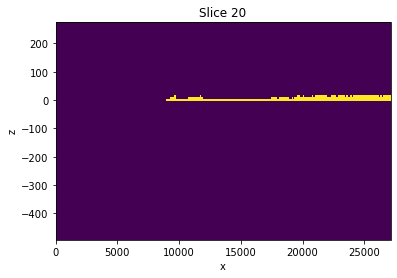

In [71]:
from SimPEG.Utils import plot2Ddata, surface2ind_topo
x_nm,y_nm = utmrotate(m_nm.modelgrid.xcellcenters.flatten(),
                              m_nm.modelgrid.ycellcenters.flatten(),
                             x0=xll,y0=yll)
x_nm -= xmll_rot
y_nm-= ymll_rot

sealevel_X,sealevel_Y = np.meshgrid(mesh.vectorCCx,mesh.vectorCCy)
sealevel_xyz = np.stack((sealevel_X.flatten(),sealevel_Y.flatten(),np.zeros(sealevel_X.size)),axis=1)
topo_xyz =np.stack((x_nm.flatten(),
                    y_nm.flatten(),
                    topo_grid.flatten()),axis=1)

actv = surface2ind_topo(mesh,topo_xyz) #True if below ground surface 
isabove_sealevel = ~surface2ind_topo(mesh,sealevel_xyz) #True if below sea level
mesh.plotSlice(isabove_sealevel&actv ,normal='Y',ind=n_pad_row,grid=False)

#### Get indices for inserted MODFLOW grids

In [72]:
ind_bot_lay_0 = np.argmin(np.abs(mesh.vectorNz- -2 ))
ind_bot_lay_19 = ind_bot_lay_0 - 19

modflow_insert = np.zeros(mesh.vnC,dtype=np.bool)
modflow_insert[n_pad_ocean:mesh.vnC[0]-n_pad_inland,
               n_pad_row:mesh.vnC[1]-n_pad_row,
               ind_bot_lay_19:ind_bot_lay_0] = True
modflow_insert = modflow_insert.flatten(order='F')


#Insert a grid from seawat into simpeg mesh (here layer_mapping_ind)
#If simpeg grid is in 1-D form
z_mesh = np.zeros(mesh.nC)
z_mesh[modflow_insert] = np.transpose(layer_mapping_ind[1:,:,:],(2,1,0)).flatten(order='F')


#If simpeg grid is in 3-D form
z_mesh = np.zeros(mesh.vnC)
z_mesh[modflow_insert.reshape(mesh.vnC,order='F')] = np.transpose(layer_mapping_ind[1:,:,:],(2,1,0)).flatten(order='C')

# mesh.plotSlice(modflow_insert,normal='Y',ind=n_pad_row,grid=False)

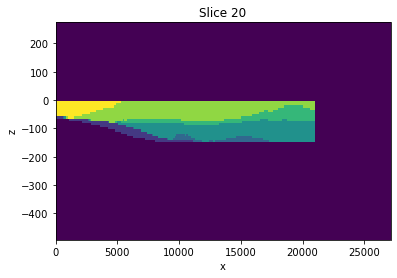

<Figure size 432x288 with 0 Axes>

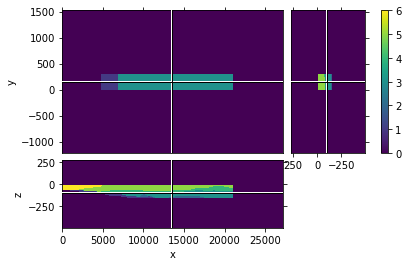

In [73]:
z_mesh = np.zeros(mesh.vnC)
z_mesh[modflow_insert.reshape(mesh.vnC,order='F')] = np.transpose(layer_mapping_ind[1:,:,:],(2,1,0)).flatten(order='C')
mesh.plotSlice(z_mesh ,normal='Y',ind=n_pad_row,grid=False)
# plt.ylim(-200,0)
# plt.xlim(0,3000)
plt.figure()
mesh.plot_3d_slicer(z_mesh)

NameError: name 'rho_grid' is not defined

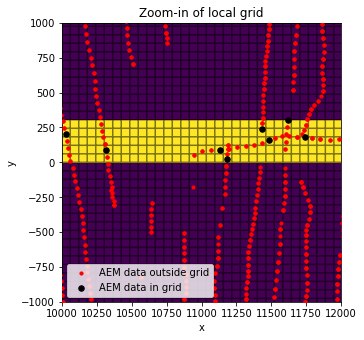

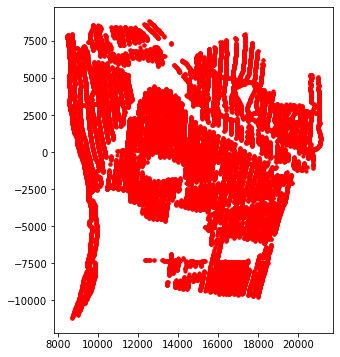

In [74]:
f,ax=plt.subplots(1,figsize=(5,6))

xtemp,ytemp =utmrotate(df.UTMX,df.UTMY)
xtemp -= xmll_rot
ytemp-= ymll_rot

plt.scatter(xtemp,ytemp,c='r',s=10,zorder=3,label='AEM data outside grid')
q = mesh.plotSlice(modflow_insert.astype(int),ind=int(ind_bot_lay_0)-1,grid=True,ax=ax,clim=(0,1))#,pcolorOpts={'alpha':0})
plt.scatter(xy[:,0],xy[:,1],c='k',s=30,zorder=4,label='AEM data in grid')

plt.xlim(10000, 12000)
plt.ylim(-1000,1000)
plt.title('Zoom-in of local grid')
ax.set_aspect(1)
plt.legend()
# plt.savefig(figdir.joinpath('Localgrid_AEMdata.png'),dpi=300,bbox_inches='tight')


f,ax=plt.subplots(1,figsize=(5,6))

plt.scatter(xtemp,ytemp,c='r',s=10,zorder=3,label='AEM data outside grid')
q = mesh.plotSlice(rho_grid,ind=int(ind_bot_lay_0)-1,grid=True,ax=ax)#,pcolorOpts={'alpha':0})
plt.scatter(xy[:,0],xy[:,1],c='k',s=30,zorder=4,label='AEM data in grid')

plt.xlim(10000, 12000)
plt.ylim(-1000,1000)
plt.title('Zoom-in of local grid')
ax.set_aspect(1)
plt.legend()


In [ ]:
rho_grid

### Create model

In [154]:
def find_ocean(m,layer_mapping_ind):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((nlay,nrow,ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m_empty,layer_mapping_ind)

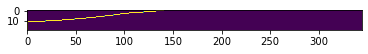

In [155]:
plt.imshow(ocean_grid[:,0,:])


In [189]:
hkSand = 100
hkClay = 1
mps180 = np.load(MPSdir.joinpath('reals','mps180_16node.npy'))
# mps180[mps180==1]=hkSand
# mps180[mps180==0]=hkClay

sigma_bulk = np.zeros_like(mps180,dtype=np.float)
sigma_bulk[mps180==0]=.1
sigma_bulk[mps180==1]=.01


#Slice it
sigma_bulk = sigma_bulk[:,rows,:]

#Set ocean resistivity 
for lay in range(sigma_bulk.shape[0]):
    for row in range(sigma_bulk.shape[1]):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        sigma_bulk[lay,row,:col]=1/0.2

rho_transf = 1/sigma_bulk
rho_background = 20.


In [190]:
rho_transf[:,np.newaxis,0,:].shape

(20, 1, 345)

In [191]:
#Row padding
rho_transf = np.append(rho_transf,
                       np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                       axis=1)


rho_transf = np.append(np.tile(rho_transf[:,np.newaxis,0,:],(1,n_pad_row,1)),
                       rho_transf,
                       axis=1)



#Inland padding
rho_transf = np.append(rho_transf,
                           rho_transf[:,:,-1].mean()*np.ones(
                               (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),axis=2)


#Ocean padding
rho_transf = np.append(rho_transf[:,:,0].min()*np.ones(
                           (rho_transf.shape[0],rho_transf.shape[1],n_pad_ocean)),
                       rho_transf,
                       axis=2)

rho_grid = np.ones(mesh.vnC)*rho_background
rho_grid[:,:,ind_bot_lay_19:ind_bot_lay_0] = rho_transf[1:,:,:].transpose((2,1,0))[:,:,::-1]
# np.transpose(rho_transf,(2,1,0))
#First layer
rho_grid[:,:,ind_bot_lay_0+1] = np.ones((mesh.vnC[0],mesh.vnC[1]))*1
rho_grid[~(actv.reshape(mesh.vnC,order='F'))] = np.nan
rho_grid = rho_grid.flatten(order='F')

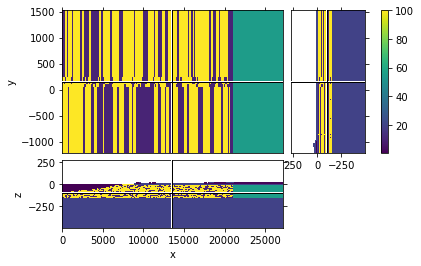

In [192]:
mesh.plot_3d_slicer(rho_grid)


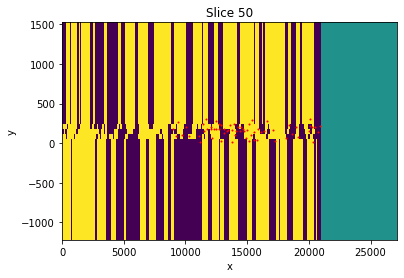

In [193]:
f,ax = plt.subplots(1)

mesh.plotSlice(rho_grid,grid=False,ax=ax)
plt.scatter(src_locations[:,0],src_locations[:,1],s=1,c='r')

# plt.xlim(20000,22000)

### Set up survey

In [199]:
#TAKEN FROM SWISMALL
survey_inputs = {
    'xy':xy,
    'Line':Line,
    'dem':dem,
    'height':height,
    'system':system,
    'rx_locations':rx_locations,
    'src_locations':src_locations,
    'topo':topo,
    'n_sounding':n_sounding
    }

In [210]:
def create_survey(mesh,survey_inputs):
    #Set source and receiver locations
    waveform_dir = datadir.joinpath('AEM','aem-waveform')
    unit_conversion = 1e-12

    i_start_hm = 10
    i_start_lm = 10

    waveform_hm_312 = np.loadtxt(waveform_dir.joinpath('waveform_hm_312.txt'))
    waveform_lm_312 = np.loadtxt(waveform_dir.joinpath('waveform_lm_312.txt'))
    time_input_currents_hm_312 = waveform_hm_312[:,0] 
    input_currents_hm_312 = waveform_hm_312[:,1]
    time_input_currents_lm_312 = waveform_lm_312[:,0] 
    input_currents_lm_312 = waveform_lm_312[:,1]

    time_gates = np.loadtxt(waveform_dir.joinpath('time_gates'))
    GateTimeShift=-2.09E-06
    MeaTimeDelay=0.000E+00
    NoGates=28
    t0_lm_312 = waveform_lm_312[:,0].max()
    times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

    GateTimeShift=-1.5E-06
    MeaTimeDelay=3.500E-04
    NoGates=37
    t0_hm_312 = waveform_hm_312[:,0].max()
    times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

    survey = get_skytem_survey(
        survey_inputs['topo'],
        survey_inputs['src_locations'],
        survey_inputs['rx_locations'],
        times_hm_312,
        time_input_currents_hm_312,
        input_currents_hm_312,
        base_frequency=25.,
        src_type="VMD",
        rx_type="dBzdt",    
        moment_type="dual",        
        time_dual_moment=times_lm_312,
        time_input_currents_dual_moment=time_input_currents_lm_312,
        input_currents_dual_moment=input_currents_lm_312,
        base_frequency_dual_moment=210.,
        wave_type="general",    
        field_type="secondary",    
    )
    return survey

def create_simulation(it,time,rho_grid,actv,mesh,survey):
    simulation_workdir = outputdir.joinpath('./tmp{}_time{}'.format(it,int(time)))
    
    simulation = GlobalSkyTEM(
        mesh, 
        sigma=1./rho_grid, 
        actv=actv, 
        parallel_option='multiprocess',
        n_cpu=2,
        work_dir=simulation_workdir.as_posix()
    )
    simulation.pair(survey)
    return simulation

def run_collect_data(simulation,rho_grid):
    print('writing inputs...\n')
    simulation.write_inputs_on_disk_pool()
    print('running simulation...\n')
    data = simulation.forward(1./rho_grid)
    print('finished simulation!')
    # DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
    # DATA_HM = -DATA[:times_hm_312.size,:]
    # DATA_LM = -DATA[times_hm_312.size:,:]
    return data


In [212]:
survey = create_survey(mesh,survey_inputs)

it= 0
time=  '01'
simulation = create_simulation(it,time,rho_grid,actv,mesh,survey)
# data = run_collect_data(simulation,rho_grid)
simulation.write_inputs_on_disk_pool()


>> Set parameters


Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-25:
Traceback (most recent call last):
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    sel

In [209]:
outputdir

PosixPath('/scratch/users/ianpg/SWIlarge/work/output')

In [ ]:
[p for p in outputdir.iterdir()]

In [167]:
print(src_locations.shape
,rx_locations.shape
,times_hm_312.shape
,time_input_currents_hm_312.shape
,input_currents_hm_312.shape
,times_lm_312.shape
,time_input_currents_lm_312.shape
,input_currents_lm_312.shape)

(65, 3) (65, 3) (27,) (19,) (19,) (18,) (19,) (19,)


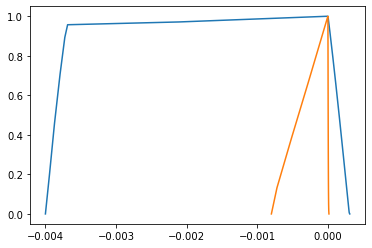

In [173]:
plt.plot(time_input_currents_hm_312,input_currents_hm_312)
plt.plot(time_input_currents_lm_312,input_currents_lm_312)


In [174]:
time_input_currents_lm_312

array([-8.0000e-04, -7.2104e-04, -5.1512e-04, -2.8195e-04,  0.0000e+00,
        2.3000e-07,  5.2000e-07,  1.1600e-06,  1.9900e-06,  3.9000e-06,
        4.8700e-06,  5.5000e-06,  6.1200e-06,  7.4100e-06,  8.1400e-06,
        8.9000e-06,  1.0580e-05,  1.2540e-05,  1.5150e-05])

In [153]:
vs = (topo,src_locations,rx_locations,times_HM_304,time_input_currents_HM_304,
        input_currents_HM_304,times_LM_304,time_input_currents_LM_304,input_currents_LM_304)
v_names = ('topo','src_locations','rx_locations','times_HM_304','time_input_currents_HM_304',
        'input_currents_HM_304','times_LM_304','time_input_currents_LM_304','input_currents_LM_304')

df_temp = pd.DataFrame(data=np.array([v_names,[v.shape for v in vs]]).T,columns=['varname','varsize'])
df_temp


,varname,varsize
0,topo,"(65, 3)"
1,src_locations,"(65, 3)"
2,rx_locations,"(65, 3)"
3,times_HM_304,"(26,)"
4,time_input_currents_HM_304,"(19,)"
5,input_currents_HM_304,"(19,)"
6,times_LM_304,"(16,)"
7,time_input_currents_LM_304,"(21,)"
8,input_currents_LM_304,"(21,)"


#### Create simulation

In [161]:
time = '00'
it = 0



In [162]:
print('writing inputs...\n')
simulation.write_inputs_on_disk_pool()
print('running simulation...\n')
data = simulation.forward(1./rho_grid)
print('finished simulation!')
# DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
# DATA_HM = -DATA[:times_hm_312.size,:]
# DATA_LM = -DATA[times_hm_312.size:,:]

writing inputs...

running simulation...



ValueError: A value in x_new is below the interpolation range.

Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Traceback (most recent call last):
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/users/ianpg/miniconda

In [116]:
import dill

In [118]:
i_src = 0

inputs = dill.load(open(Path(simulation_workdir).joinpath("inputs_{}.pkl".format(i_src)).as_posix(), 'rb'))


### I am here

In [ ]:
np.cumprod(mesh.vnC)

In [28]:
src_locations

array([[2.03526655e+04, 1.94546872e+01, 4.46100000e+01],
       [2.03097732e+04, 4.94710340e+01, 4.53200000e+01],
       [2.02679699e+04, 8.18056331e+01, 4.68300000e+01],
       ...,
       [2.09275809e+04, 2.66491655e+02, 4.76600000e+01],
       [2.09275809e+04, 2.66491655e+02, 4.76600000e+01],
       [2.09549068e+04, 2.94031698e+02, 5.03600000e+01]])

In [131]:
sigma_interpolator  =inputs['sigma_interpolator']
mesh_local = inputs['mesh_local']
actv_local = inputs['actv_local']


In [132]:
values = sigma_interpolator(mesh_local.gridCC[actv_local,:])

In [136]:
# i_src, work_dir, n_thread = args
# mkl_set_num_threads(n_thread)
from SimPEG import EM
from  pymatsolver import Pardiso


mesh_local = inputs['mesh_local']
actv_local = inputs['actv_local']
sigma_interpolator = inputs['sigma_interpolator']
srcloc = inputs['srcloc']
rxloc = inputs['rxloc']
time = inputs['time']
time_input_currents = inputs['time_input_currents']
input_currents = inputs['input_currents']
base_frequency = inputs['base_frequency']
time_dual_moment = inputs['time_dual_moment']
time_input_currents_dual_moment = inputs['time_input_currents_dual_moment']
input_currents_dual_moment = inputs['input_currents_dual_moment']
base_frequency_dual_moment = inputs['base_frequency_dual_moment']

values = sigma_interpolator(mesh_local.gridCC[actv_local,:])
sigma_local = np.ones(mesh_local.nC) * 1e-8
sigma_local[actv_local] = values

rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb = ProblemSkyTEM(mesh_local, sigma=sigma_local, verbose=False)
dts = np.diff(np.logspace(-6, -1, 50))
prb.timeSteps = [
    (3e-7, 6),(1e-6, 5),(2e-6, 5),(5e-6, 5),
    (1e-5, 5),(2e-5, 5),(5e-5, 5),(1e-4, 5),
    (2e-4, 5),(5e-4, 5),(1e-3, 15)
]
prb.Solver = Pardiso
prb.pair(survey)
data = prb.simulate(
        sigma_local,
        time,
        time_dual_moment,
        time_input_currents,
        input_currents,
        time_input_currents_dual_moment,
        input_currents_dual_moment,
        base_frequency=base_frequency,
        base_frequency_dual_moment=base_frequency_dual_moment
)

ValueError: A value in x_new is below the interpolation range.

In [ ]:
interp()

In [ ]:
def run_simulation_skytem(args):
    """
    run_simulation_skytem
    --------------
    """
    #DEACTIVATED BECAUSE I CANNOT GET MKL TO  IMPORT
    from pyMKL import mkl_set_num_threads
    i_src, work_dir, n_thread = args
    mkl_set_num_threads(n_thread)
    inputs = dill.load(open(Path(work_dir).joinpath("inputs_{}.pkl".format(i_src)).as_posix(), 'rb'))
    mesh_local = inputs['mesh_local']
    actv_local = inputs['actv_local']
    sigma_interpolator = inputs['sigma_interpolator']
    srcloc = inputs['srcloc']
    rxloc = inputs['rxloc']
    time = inputs['time']
    time_input_currents = inputs['time_input_currents']
    input_currents = inputs['input_currents']
    base_frequency = inputs['base_frequency']
    time_dual_moment = inputs['time_dual_moment']
    time_input_currents_dual_moment = inputs['time_input_currents_dual_moment']
    input_currents_dual_moment = inputs['input_currents_dual_moment']
    base_frequency_dual_moment = inputs['base_frequency_dual_moment']

    values = sigma_interpolator(mesh_local.gridCC[actv_local,:])
    sigma_local = np.ones(mesh_local.nC) * 1e-8
    sigma_local[actv_local] = values

    rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
    src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
    survey = EM.TDEM.Survey([src])
    prb = ProblemSkyTEM(mesh_local, sigma=sigma_local, verbose=False)
    dts = np.diff(np.logspace(-6, -1, 50))
    prb.timeSteps = [
        (3e-7, 6),(1e-6, 5),(2e-6, 5),(5e-6, 5),
        (1e-5, 5),(2e-5, 5),(5e-5, 5),(1e-4, 5),
        (2e-4, 5),(5e-4, 5),(1e-3, 15)
    ]
    prb.Solver = Pardiso
    prb.pair(survey)
    data = prb.simulate(
            sigma_local,
            time,
            time_dual_moment,
            time_input_currents,
            input_currents,
            time_input_currents_dual_moment,
            input_currents_dual_moment,
            base_frequency=base_frequency,
            base_frequency_dual_moment=base_frequency_dual_moment
    )
    return data


In [123]:
import importlib
importlib.reload(simpegskytem)

<module 'simpegskytem' from '../../simpegskytem/__init__.py'>

In [ ]:
def forward(self, m):

    self.model = m

    if self.verbose:
        print(">> Compute response")
    if self.parallel_option == 'multiprocess':
        pool = Pool(self.n_cpu)
        # This assumes the same # of layer for each of soundings
        results = pool.map(
            run_simulation_skytem,
            [(i_src, self.work_dir, self.n_thread) for i_src in range(self.n_sounding)]
        )
        pool.close()
        pool.join()


In [ ]:
def create_simulation(it,time,rho_grid,actv,mesh,survey):
    simulation_workdir = datadir.joinpath('./tmp{}_time{}'.format(it,int(time)))
    try:
        simulation_workdir.mkdir()
    except:
        pass

    simulation = GlobalSkyTEM(
        mesh, 
        sigma=1./rho_grid, 
        actv=actv, 
        parallel_option='multiprocess',
        n_cpu=4,
        work_dir=simulation_workdir.as_posix()
    )
    simulation.pair(survey)
    return simulation

def run_collect_data(simulation,rho_grid):
    print('writing inputs...\n')
    simulation.write_inputs_on_disk_pool()
    print('running simulation...\n')
    data = simulation.forward(1./rho_grid)
    print('finished simulation!')
    # DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
    # DATA_HM = -DATA[:times_hm_312.size,:]
    # DATA_LM = -DATA[times_hm_312.size:,:]
    return data

In [ ]:
hm_times_TEM_304 = [5.93150e-05,6.08150e-05,6.28150e-05,6.48150e-05,6.68150e-05,6.88200e-05,7.08100e-05,7.33200e-05,
                    7.68100e-05,8.13100e-05,8.68100e-05,9.38200e-05,1.02810e-04,1.14310e-04,1.28810e-04,1.46810e-04,
                    1.69300e-04,1.97300e-04,2.32800e-04,2.78300e-04,3.35300e-04,4.07300e-04,4.98300e-04,6.12300e-04,
                    7.56300e-04,9.37800e-04,1.16660e-03,1.45460e-03,1.81860e-03,2.27760e-03,2.85560e-03,3.57460e-03,
                    4.45460e-03,5.53160e-03,6.84960e-03,8.46360e-03,1.04386e-02]

lm_times_TEM_304 = [1.00000e-07,4.15000e-07,2.41500e-06,4.41500e-06,6.41500e-06,8.42000e-06,1.04100e-05,1.29200e-05,
                    1.64100e-05,2.09100e-05,2.64100e-05,3.34200e-05,4.24100e-05,5.39100e-05,6.84100e-05,8.64100e-05,
                    1.08900e-04,1.36900e-04,1.72400e-04,2.17900e-04,2.74900e-04,3.46900e-04,4.37900e-04,5.51900e-04,
                    6.95900e-04,8.77400e-04,1.10620e-03,1.39420e-03]

In [ ]:
times = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if system[i_sounding]==312:
        times.append(times_HM_312)
        time_dual_moment.append(times_LM_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)  
    elif system[i_sounding]==304:
        times.append(times_HM_304)
        time_dual_moment.append(times_LM_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)      

In [ ]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps)

mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations[:,:],
    src_locations = src_locations[:,:],    
    topo = topo[:,:],
    time = times,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=4,
    Solver=PardisoSolver
)
prob.pair(survey)

In [ ]:
pad_amt = 0
iskip = 2
nlay,nrow,ncol = (26, 20, 100)
dx,dy,dz = (30,30,3)
Lx,Ly,Lz = (dx*ncol,dy*nrow,dz*nlay)
xmin, xmax = pad_amt, Lx-pad_amt
ymin, ymax = pad_amt, Ly-pad_amt

# generate survey
x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
y_inds = np.argwhere(np.logical_and(mesh.vectorCCy > ymin, mesh.vectorCCy < ymax))
x = mesh.vectorCCx[x_inds][::iskip]
y = mesh.vectorCCy[y_inds][::iskip]
# f_dem = NearestNDInterpolator(dem[:,:2], dem[:,2])
xy = Utils.ndgrid(x, y)


In [ ]:
mesh.vectorCCx.shape

In [5]:
def create_survey(mesh,pad_amt=0,iskip=2):
    #Set source and receiver locations
    nlay,nrow,ncol = (26, 20, 100)
    dx,dy,dz = (30,30,3)
    Lx,Ly,Lz = (dx*ncol,dy*nrow,dz*nlay)
    xmin, xmax = pad_amt, Lx-pad_amt
    ymin, ymax = pad_amt, Ly-pad_amt

    # generate survey
    x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
    y_inds = np.argwhere(np.logical_and(mesh.vectorCCy > ymin, mesh.vectorCCy < ymax))
    x = mesh.vectorCCx[x_inds][::iskip]
    y = mesh.vectorCCy[y_inds][::iskip]
    # f_dem = NearestNDInterpolator(dem[:,:2], dem[:,2])
    xy = Utils.ndgrid(x, y)
    # z = f_dem(xy)

    #Source and receiver height
    z = np.zeros(len(xy))
    src_height = 30.
    src_locations = np.c_[xy, z + src_height]
    rx_locations = np.c_[xy[:,0]+13.25, xy[:,1], z+2.+ src_height]
    topo = np.c_[xy, z]
    n_sounding = src_locations.shape[0]
    print(n_sounding)

    unit_conversion = 1e-12

    i_start_hm = 10
    i_start_lm = 10

    waveform_hm_312 = np.loadtxt('../aem-waveform/waveform_hm_312.txt')
    waveform_lm_312 = np.loadtxt('../aem-waveform/waveform_lm_312.txt')
    time_input_currents_hm_312 = waveform_hm_312[:,0] 
    input_currents_hm_312 = waveform_hm_312[:,1]
    time_input_currents_lm_312 = waveform_lm_312[:,0] 
    input_currents_lm_312 = waveform_lm_312[:,1]

    time_gates = np.loadtxt(('../aem-waveform/time_gates'))
    GateTimeShift=-2.09E-06
    MeaTimeDelay=0.000E+00
    NoGates=28
    t0_lm_312 = waveform_lm_312[:,0].max()
    times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

    GateTimeShift=-1.5E-06
    MeaTimeDelay=3.500E-04
    NoGates=37
    t0_hm_312 = waveform_hm_312[:,0].max()
    times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

    survey = get_skytem_survey(
        topo,
        src_locations,
        rx_locations,
        times_hm_312,
        time_input_currents_hm_312,
        input_currents_hm_312,
        base_frequency=25.,
        src_type="VMD",
        rx_type="dBzdt",    
        moment_type="dual",        
        time_dual_moment=times_lm_312,
        time_input_currents_dual_moment=time_input_currents_lm_312,
        input_currents_dual_moment=input_currents_lm_312,
        base_frequency_dual_moment=210.,
        wave_type="general",    
        field_type="secondary",    
    )
    return survey


In [6]:

def create_model(sigma_bulk,mesh):
    rho_transf = 1/sigma_bulk
    n_pad_ocean = 20
    n_pad_inland = 20
    n_pad_row = 20

    # #Air padding

    #Row padding
    rho_transf = np.append(rho_transf,
                           np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                           axis=1)
    rho_transf = np.append(np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                           rho_transf,
                           axis=1)
    #Ocean padding
    rho_transf = np.append(rho_transf,
                               rho_transf[:,:,-1].min()*np.ones(
                                   (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),axis=2)



    #Inland padding
    rho_transf = np.append(rho_transf[:,:,0].mean()*np.ones(
                               (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),
                           rho_transf,
                           axis=2)


    rho_background = 20.
    rho_grid = np.ones(mesh.vnC,order='F') * rho_background
    inds_insert = np.logical_and(mesh.vectorCCz> -26*3, mesh.vectorCCz <0)
    
    rho_grid[:,:,inds_insert] = np.transpose(rho_transf,(2,1,0))[:,:,::-1]
    rho_grid = rho_grid.flatten(order='F')
    rho_grid[mesh.gridCC[:,2]>0.] = np.nan

    actv = np.ones_like(rho_grid,dtype=bool)
    actv[mesh.gridCC[:,2]>0.] = False
    return rho_grid, actv


In [7]:
mesh = create_mesh()

sigma_bulk = 


create_model(sigma_bulk,mesh

SyntaxError: invalid syntax (<ipython-input-7-91ed01399720>, line 3)